In [1]:
import pandas as pd
import tensorflow as tf
from transformers import AutoTokenizer
import re
from transformers import AdamWeightDecay
from datasets import Dataset
import math
import numpy as np
from transformers import DataCollatorForSeq2Seq
from transformers import TFAutoModelForSeq2SeqLM
import torch
import matplotlib.pyplot as plt
import evaluate
from transformers import T5Tokenizer, T5Config, T5ForConditionalGeneration
import torch

2023-11-21 07:33:03.548918: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-21 07:33:03.548942: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-21 07:33:03.548967: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-21 07:33:03.553989: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-21 07:33:04.065883: W tensorflow/compiler/

In [2]:
tf.config.experimental.list_physical_devices(device_type='GPU')

2023-11-21 07:33:05.974578: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-21 07:33:05.978184: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-21 07:33:05.978343: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
def json_to_dataframe(filename):
    f = open(filename)
    df = pd.read_json(f)
    print(df.iloc[0])
    f.close()
    #df["masked headline"]= df.apply(lambda x: x['masked headline'].replace('____', str(x['ans'])), axis=1)
    print(df.iloc[0])
    df['news'] = df['news'].apply(lambda x: re.sub(r'\([^)]*\)', '', x))
    df['masked headline'] = df['masked headline'].str.replace('____', '<extra_id_0> ') + ' </s>'
    df['text'] = df[['news', 'masked headline']].apply(" ".join, axis=1)
    df = df.astype(str)
    return df

In [5]:
train_data = json_to_dataframe('Train_Numerical_Reasoning.json')

news               (Oct 7, 2014  12:40 PM CDT) As of Jan. 1, Walm...
masked headline    ____K Walmart Part-Timers to Lose Health Insur...
calculation                                     Paraphrase(30,000,K)
ans                                                               30
Name: 0, dtype: object
news               (Oct 7, 2014  12:40 PM CDT) As of Jan. 1, Walm...
masked headline    ____K Walmart Part-Timers to Lose Health Insur...
calculation                                     Paraphrase(30,000,K)
ans                                                               30
Name: 0, dtype: object


In [6]:
train_data.head()

news  \
0   As of Jan. 1, Walmart will no longer offer 30...   
1   Dax Shepard and Kristen Bell got married at t...   
2   Nancy Reagan, the helpmate, backstage adviser...   
3   American Airlines faces FAA fines of more tha...   
4   Ingrid Lyne, the Seattle mom allegedly murder...   

                                     masked headline            calculation  \
0  <extra_id_0> K Walmart Part-Timers to Lose Hea...   Paraphrase(30,000,K)   
1  Dax Shepard: Wedding to Kristen Bell Cost $<ex...              Copy(142)   
2            Nancy Reagan Dead at <extra_id_0>  </s>               Copy(94)   
3  American Airlines Faces $<extra_id_0> M Fine f...                Copy(7)   
4  $<extra_id_0> K Raised for Kids of Mom Dismemb...  Paraphrase(222,000,K)   

   ans                                               text  
0   30   As of Jan. 1, Walmart will no longer offer 30...  
1  142   Dax Shepard and Kristen Bell got married at t...  
2   94   Nancy Reagan, the helpmate, backstage adviser...  
3    7   American Airlines faces FAA fines of more tha...  
4  222   Ingrid Lyne, the Seattle mom allegedly murder...

In [7]:
dataset = Dataset.from_pandas(train_data)
dataset = dataset.train_test_split(test_size=0.2)

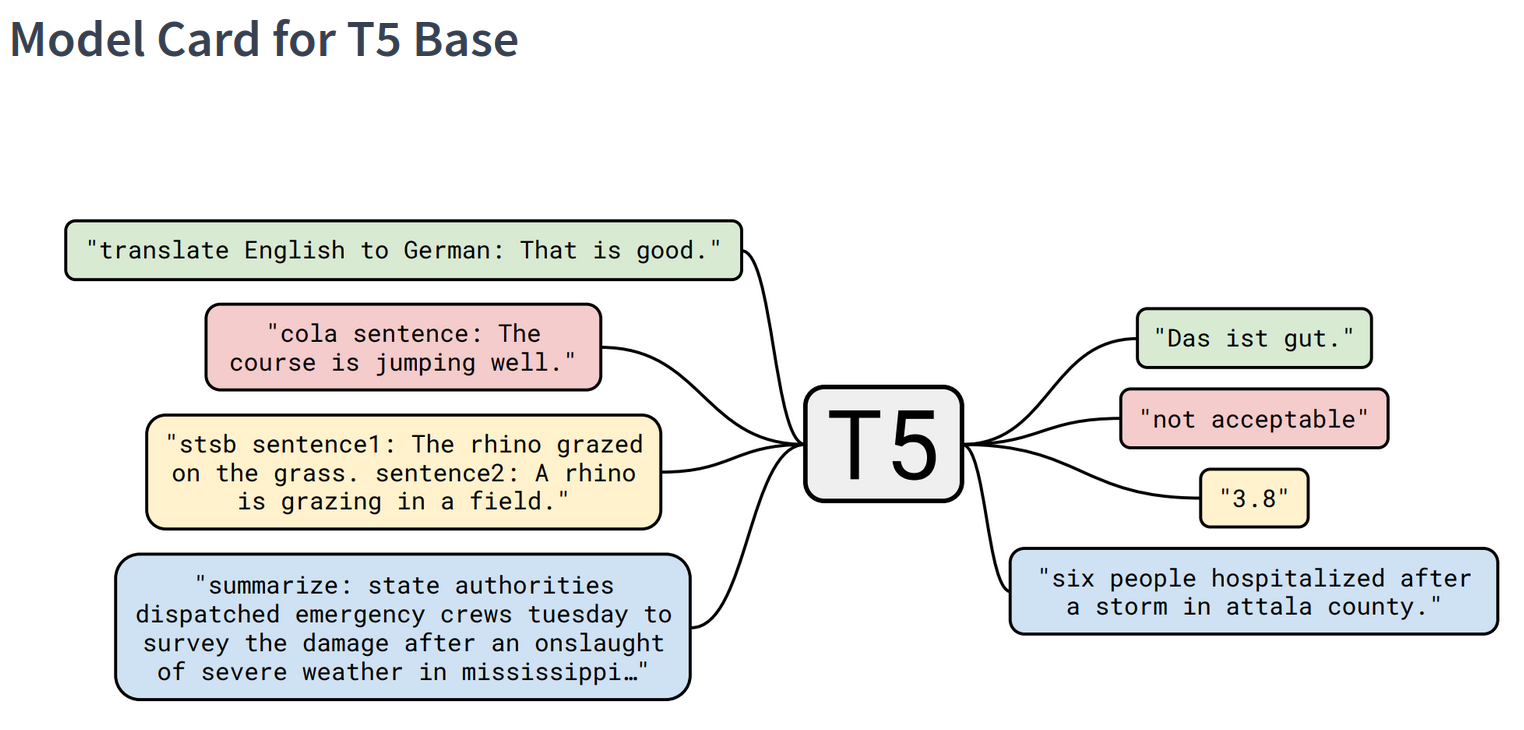

T5 is Text-to-Text-Transfer-Transformer model. It takes input texts for various NLP tasks and outputs the text for that respective task. 

T5 is slightly different from Masked Language Model such as BERT. Masked Language Models are Bidirectional models which use Mask token for each word while T5 replaces multiple consecutive tokens with a single Mask keyword. Since the final objective is to have trained a model that inputs text and outputs text, the targets were designed to produce a sequence, unlike BERT, that tries to output one word (itself). So t5 is suitable for text summarization and headline generation.

In [8]:
model_name = "Michau/t5-base-en-generate-headline"

### The model is based on t5-base and has been trained on a collection of 500k articles with headings. Its purpose is to create a one-line heading suitable for the given article. https://huggingface.co/Michau/t5-base-en-generate-headline

In [6]:
'''
model_names = ["it5/it5-base-headline-generation", 
               "it5/it5-small-headline-generation",
               "it5/mt5-base-headline-generation",
               "it5/mt5-small-headline-generation", 
               "it5/it5-efficient-small-el32-headline-generation",
               "Michau/t5-base-en-generate-headline"]
'''

'\nmodel_names = ["it5/it5-base-headline-generation", \n               "it5/it5-small-headline-generation",\n               "it5/mt5-base-headline-generation",\n               "it5/mt5-small-headline-generation", \n               "it5/it5-efficient-small-el32-headline-generation",\n               "Michau/t5-base-en-generate-headline"]\n'

To prefix the input with a prompt so T5 knows this is a headline generation task

In [87]:
'''
prefix = "headline: "
#max_len = 3024
max_len = 2024
#max_l = 1028
max_l = 128
'''

In [9]:
def preprocess_function(examples):   
    #inputs = [prefix + doc for doc in examples["news"]]
    inputs = tokenizer(examples['text'],max_length=3066,  truncation=True)
    labels = tokenizer(text_target=examples["calculation"], max_length=248, truncation=True)
    inputs["labels"] = labels["input_ids"]
    return inputs

To apply the preprocess function over the entire dataset

In [10]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [11]:
tokenized = dataset.map(preprocess_function, batched=True, #num_proc=4,
                        remove_columns=dataset['train'].column_names)

Map:   0%|          | 0/16925 [00:00<?, ? examples/s]

Map:   0%|          | 0/4232 [00:00<?, ? examples/s]

In [10]:
#tokenized = train_data.map(preprocess_function, batched=True)

To create batches using DataCollatorForSeq2Seq, which dynamically pads the sentences to the longest length in a batch during collation. This is  more efficient than padding the whole dataset to the maximum length. 

In [12]:
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer,
                                           model=model_name,
                                           return_tensors="tf")
#optimizer = AdamWeightDecay(learning_rate=1e-4, weight_decay_rate=0.01)
#optimizer = AdamWeightDecay(learning_rate=7e-5, weight_decay_rate=0.01)
optimizer = AdamWeightDecay(learning_rate=5e-5, weight_decay_rate=0.01)

To load pretrained T5-base michau with AutoModelForSeq2SeqLM

In [13]:
model = TFAutoModelForSeq2SeqLM.from_pretrained(model_name)

2023-11-21 07:33:23.941056: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-21 07:33:23.941241: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-21 07:33:23.941376: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

To convert datasets to the tf.data.Dataset format 

In [14]:
tf_train_set = model.prepare_tf_dataset(
    tokenized["train"],
    shuffle=True,
    batch_size=3,
    collate_fn=data_collator,
)

tf_test_set = model.prepare_tf_dataset(
    tokenized["test"],
    shuffle=False,
    batch_size=3,
    collate_fn=data_collator,
)

You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [15]:
model.compile(optimizer=optimizer)

In [17]:
eval_loss = model.evaluate(tf_test_set)
print(f"Pretrained LM Perplexity: {math.exp(eval_loss):.2f}")

265/265 [==============================] - 61s 199ms/step - loss: 0.9788
Pretrained LM Perplexity: 2.66


In [16]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=1)
history = model.fit(x=tf_train_set, validation_data=tf_test_set,callbacks=[callback], epochs=10)
#model.fit(x=tf_train_set, validation_data=tf_test_set, batch_size=6, epochs=1)
#eval_loss = model.evaluate(tf_test_set)
#print(f"Finetuned Perplexity: {math.exp(eval_loss):.2f}")

Epoch 1/10
5641/5641 [==============================] - 1291s 226ms/step - loss: 0.4756 - val_loss: 0.2766
Epoch 2/10
5641/5641 [==============================] - 1271s 225ms/step - loss: 0.2548 - val_loss: 0.2543
Epoch 3/10
5641/5641 [==============================] - 1273s 226ms/step - loss: 0.1956 - val_loss: 0.2475
Epoch 4/10
5641/5641 [==============================] - 1296s 230ms/step - loss: 0.1604 - val_loss: 0.2470
Epoch 5/10
5641/5641 [==============================] - 1295s 230ms/step - loss: 0.1336 - val_loss: 0.2521


In [19]:
eval_loss = model.evaluate(tf_test_set)
print(f"Finetuned Perplexity: {math.exp(eval_loss):.2f}")

265/265 [==============================] - 53s 201ms/step - loss: 0.0442
Finetuned Perplexity: 1.05


In [24]:
def preprocess_function2(examples):   
    inputs = tokenizer(examples['calculation'],max_length=248,  truncation=True)
    #labels = tokenizer(text_target=examples["headline"], max_length=128, truncation=True)
    labels = tokenizer(text_target=examples["ans"], max_length=64, truncation=True)
    inputs["labels"] = labels["input_ids"]
    return inputs

In [25]:
tokenized2 = dataset.map(preprocess_function2, batched=True, #num_proc=4,
                        remove_columns=dataset['train'].column_names)

Map:   0%|          | 0/16925 [00:00<?, ? examples/s]

Map:   0%|          | 0/4232 [00:00<?, ? examples/s]

In [27]:
model2 = TFAutoModelForSeq2SeqLM.from_pretrained(model_name, from_pt=True)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFT5ForConditionalGeneration: ['lm_head.weight', 'decoder.embed_tokens.weight', 'encoder.embed_tokens.weight']
- This IS expected if you are initializing TFT5ForConditionalGeneration from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFT5ForConditionalGeneration from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFT5ForConditionalGeneration were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


In [28]:
tf_train_set2 = model2.prepare_tf_dataset(
    tokenized2["train"],
    shuffle=True,
    batch_size=3,
    collate_fn=data_collator,
)

tf_test_set2 = model2.prepare_tf_dataset(
    tokenized2["test"],
    shuffle=False,
    batch_size=3,
    collate_fn=data_collator,
)

In [29]:
model2.compile(optimizer=optimizer)
history2 = model2.fit(x=tf_train_set2, validation_data=tf_test_set2, callbacks=[callback], epochs=7)

Epoch 1/7
5641/5641 [==============================] - 587s 102ms/step - loss: 0.1975 - val_loss: 0.1367
Epoch 2/7
5641/5641 [==============================] - 573s 102ms/step - loss: 0.1378 - val_loss: 0.1226
Epoch 3/7
5641/5641 [==============================] - 575s 102ms/step - loss: 0.1158 - val_loss: 0.1209
Epoch 4/7
5641/5641 [==============================] - 569s 101ms/step - loss: 0.1026 - val_loss: 0.1196
Epoch 5/7
5641/5641 [==============================] - 572s 101ms/step - loss: 0.0902 - val_loss: 0.1196


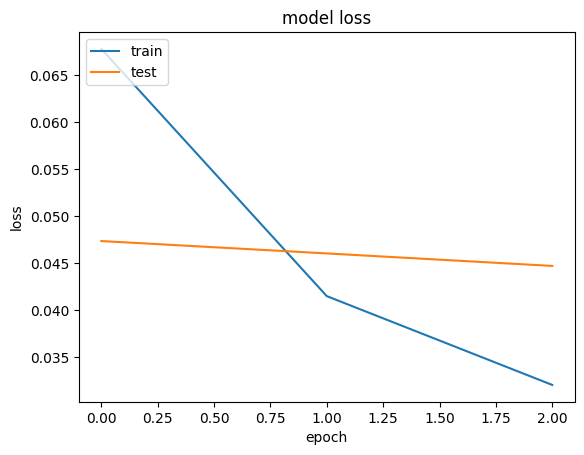

In [18]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [17]:
f = open('Dev_Numerical_Reasoning.json')
df = pd.read_json(f)
df['news'] = df['news'].apply(lambda x: re.sub(r'\([^)]*\)', '', x))
df['masked headline'] = df['masked headline'].str.replace('____', '<extra_id_0> ') + ' </s>'
df['text'] = df[['news', 'masked headline']].apply(" ".join, axis=1)
df = df.astype(str)
#df = df.iloc[:200]
#df = df.iloc[100:500]
f.close()
test_data = Dataset.from_pandas(df)

In [18]:
# Try improved version
def t5_predictions(data, tokenizer, model):
    text = data['text']
    headline = data['calculation']

    inputs = tokenizer.encode_plus(text, add_special_tokens=True,
                                   return_tensors="pt").input_ids
    # input_ids = inputs['input_ids'].to(device)
    # attention_masks = inputs['attention_mask']

    outputs = model.generate(inputs,
                             max_length=128, num_beams=5, early_stopping=True)


    res = ''
    results = tokenizer.decode(outputs[0][1:], skip_special_tokens=False,
                               clean_up_tokenization_spaces=False)
    return results

        

In [19]:
cal = []
for i in test_data:
    cal.append(t5_predictions(i, tokenizer, model))


2023-11-21 09:20:36.400418: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fd164055c40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-21 09:20:36.400435: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2023-11-21 09:20:36.407723: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-21 09:20:36.612752: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-11-21 09:20:36.652288: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [23]:
updated_cal

['Trans(three)',
 'Copy(12)',
 'Round(305.45,0)',
 'Copy(1)',
 'Copy(10)',
 'Copy(1959)',
 'Copy(218)',
 'Trans(five)',
 'Paraphrase(2,000,K)',
 'Copy(60)',
 'Copy(25)',
 'Copy(6)',
 'Span(a trillion)',
 'Trans(four)',
 'Trans(third)',
 'Copy(30)',
 'Copy(20)',
 'Trans(five)',
 'Copy(55)',
 'Copy(65)',
 'Copy(20)',
 'Copy(1.1)',
 'Copy(11)',
 'Copy(50)',
 'Copy(2010)',
 'Trans(third)',
 'Copy(74)',
 'Copy(60)',
 'Paraphrase(5,000,K)',
 'Copy(2)',
 'Trans(seven)',
 'Copy(90)',
 'Copy(77)',
 'Copy(4)',
 'Paraphrase(500,000,K)',
 'Copy(30)',
 'Trans(two)',
 'Copy(2012)',
 'Copy(70)',
 'Copy(15)',
 'Copy(26)',
 'Copy(60)',
 'Trans(nine)',
 'Copy(162)',
 'Paraphrase(25,000,K)',
 'Copy(37)',
 'Copy(86)',
 'Copy(31)',
 'Copy(11)',
 'Copy(7)',
 'Copy(100)',
 'Trans(two)',
 'Trans(two)',
 'Trans(four)',
 'Trans(three)',
 'Copy(11)',
 'Trans(Two)',
 'Copy(900)',
 'Copy(1791)',
 'Copy(2)',
 'Copy(40)',
 'Trans(two)',
 'Subtract(2018,5)',
 'Copy(2.9)',
 'Copy(370)',
 'Copy(285)',
 'Copy(232)',
 'C

In [20]:
updated_cal = []
for c in cal:
    updated_cal.append(c.split('<')[0])

In [25]:
test_data['calculation']

['Trans(three)',
 'Copy(12)',
 'Round(305.45,0)',
 'Copy(1)',
 'Copy(10)',
 'Copy(1959)',
 'Copy(218)',
 'Round(Divide(268,30),0)',
 'Paraphrase(2,000,K)',
 'Copy(60)',
 'Copy(25)',
 'Copy(6)',
 'Round(1.29,0)',
 'Copy(4)',
 'Trans(third)',
 'Copy(30)',
 'Copy(20)',
 'Trans(five)',
 'Copy(55)',
 'Copy(65)',
 'Copy(20)',
 'Copy(2)',
 'Copy(6)',
 'Copy(50)',
 'Subtract(2011,11)',
 'Copy(3)',
 'Copy(74)',
 'Copy(60)',
 'Paraphrase(5,000,K)',
 'Copy(2)',
 'Trans(seven)',
 'Copy(90)',
 'Copy(77)',
 'Copy(4)',
 'Paraphrase(500,000,K)',
 'Copy(30)',
 'Trans(two)',
 'Copy(2012)',
 'Copy(70)',
 'Copy(15)',
 'Copy(26)',
 'Copy(60)',
 'Trans(nine)',
 'Copy(162)',
 'Paraphrase(25,000,K)',
 'Copy(37)',
 'Copy(86)',
 'Copy(31)',
 'Copy(11)',
 'Copy(7)',
 'Copy(100)',
 'Trans(Two)',
 'Add(Span(Arizona),Span(Missouri))',
 'Trans(four)',
 'Trans(three)',
 'Copy(11)',
 'Trans(Two)',
 'Copy(900)',
 'Copy(1791)',
 'Trans(two) ',
 'Copy(40)',
 'Trans(two)',
 'Copy(5)',
 'Copy(2.9)',
 'Copy(370)',
 'Copy(28

To load the ROUGE metric which stands for Recall-Oriented Understudy for Gisting Evaluation to calculates the similarity between the predicted headlines and actual headlines. ROUGE-N measures the number of matching n-grams between the model-generated text and an actual headline.



In [30]:
def t5_predictions2(data, tokenizer, model):


    inputs = tokenizer.encode_plus(data, add_special_tokens=True,
                                   return_tensors="pt").input_ids
    # input_ids = inputs['input_ids'].to(device)
    # attention_masks = inputs['attention_mask']

    outputs = model.generate(inputs,
                             max_length=128, num_beams=5, early_stopping=True)


    res = ''
    results = tokenizer.decode(outputs[0][1:], skip_special_tokens=False,
                               clean_up_tokenization_spaces=False)
    res = re.findall(r"([\d:,./]+)", results)
    return res[0]

In [25]:
test_data['ans']

['3',
 '12',
 '305',
 '1',
 '10',
 '1959',
 '218',
 '9',
 '2',
 '60',
 '25',
 '6',
 '1',
 '4',
 '3',
 '30',
 '20',
 '5',
 '55',
 '65',
 '20',
 '2',
 '6',
 '50',
 '2000',
 '3',
 '74',
 '60',
 '5',
 '2',
 '7',
 '90',
 '77',
 '4',
 '500',
 '30',
 '2',
 '2012',
 '70',
 '15',
 '26',
 '60',
 '9',
 '162',
 '25',
 '37',
 '86',
 '31',
 '11',
 '7',
 '100',
 '2',
 '2',
 '4',
 '3',
 '11',
 '2',
 '900',
 '1791',
 '2',
 '40',
 '2',
 '5',
 '2.9',
 '370',
 '285',
 '232',
 '5',
 '19',
 '1',
 '100',
 '2',
 '9/11',
 '60',
 '30',
 '59',
 '3',
 '9',
 '800',
 '2.8',
 '6',
 '3',
 '1',
 '50',
 '90',
 '4.5',
 '81',
 '2',
 '44',
 '350',
 '1',
 '14',
 '5',
 '2.0',
 '2',
 '25',
 '74',
 '370',
 '31',
 '8',
 '400',
 '61',
 '47',
 '911',
 '3',
 '500',
 '100',
 '17',
 '160',
 '25',
 '47',
 '44',
 '21',
 '16',
 '50',
 '100',
 '2',
 '69',
 '21',
 '3.3',
 '21',
 '3',
 '2',
 '2',
 '92',
 '2',
 '18',
 '9',
 '1',
 '29',
 '2',
 '4',
 '85',
 '3',
 '1892',
 '17',
 '3',
 '94',
 '4',
 '13',
 '2',
 '6',
 '6',
 '25',
 '22',
 '2',

In [31]:
false=0
for x,y in zip(updated_cal, test_data['ans']):
    ans = t5_predictions2(x, tokenizer, model2)
    if ans != y:
        print(ans)
        print(y)
        print("")
        false += 1


5
9

1.1
2

11
6

2010
2000

1771
1791

2017
5

1990
30

2
59

4
4.5

12
44

700
350

25
31

9
47

79.5
160

100
44

1
69

1988
21

16
29

3
4

25
85

121
1892

2
17

12
13

30
2

10
12

4
26

91
62

75
3

5
2

10
15.5

109
100

4
2

9.99
6

26
27

200
800

26.6
28.6

50
2

3.1
3

229
230

5
11

10
20

3
1

7
12

513
500

2020
2010

6
51

2
3

34
1981

905
900

169,000
19

10
12

12
10

12
120

47
75

150
5

10
12

6
25

400
40

40
30

10
2

33
30

18
21

70
72

10
31

25
12

98
9.8

28
73

10
11

27
27.2

10
15

50
30

39
38

23
1958

04
05

60
560

6
5

3
5,000

1.5
2.9

8.5
5

2
2014

30
32

2
1906

2004
9/11

2
1

12
50

7
7.5

70.3
70

204.6
205

50
99

200
221

47
150

7.7
8

10.9
11

187
2

6.2
6

1.11
1.1

44.7
45

40
43

13
2

25
30

10
8

98
998

10
11

2
88

1
1.9

4
2

3
4

46.7
48.7

2
40

50
2050

45
66

1649
1629

2
4

480
500

2
78

5
6

5
11

100
0.99

40
39

5
4

25
70

34
25

31.31
33

12
2

1981
1991

800
1200

2011
1

273
270

359
459

1,400
20

36
35

3.12
3

2008

In [28]:
# 11/21

In [32]:
false

312

In [33]:
1-false/len(test_data['ans'])

0.8786936236391913